In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)


perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [6]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [7]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [8]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [9]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values; 

In [10]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask_modified, drop=False).values

In [11]:
s = 100

dT2 = np.zeros(T2.shape)
T2_smooth = np.zeros(T2.shape)

for t in range(0,T2.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    T2_smooth[t] = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_smooth[t]
    

0
10
20


In [10]:
my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/dT2_day_feb.npy', [dT2])

In [12]:
T_diff = sst_day - T2

s = 100

dT_diff = np.zeros(T2.shape)
T_diff_smooth = np.zeros(T2.shape)

for t in range(0,T2.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    T_diff_smooth[t] = gm.nan_gaussian_filter(T_diff[t],s)                             
    dT_diff[t] = T_diff[t] - T_diff_smooth[t]
    

0
10
20


In [13]:
### LOAD ANOMALIES DATA FROM SAVED FILES

ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day']*sea_mask_modified_nan
    
# with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
#     dPBLH_day = np.load(f)

Text(0.75, -0.2, '3.3%')

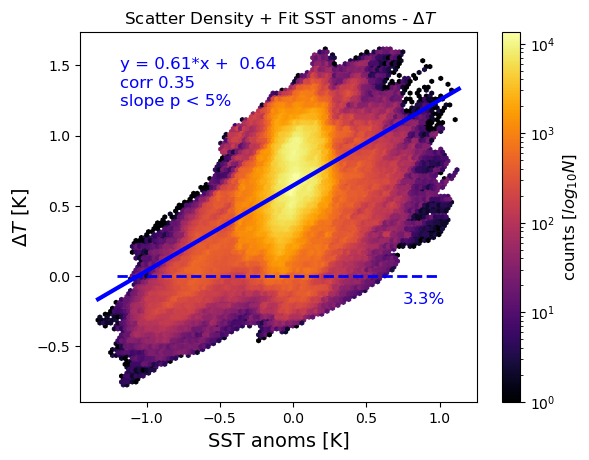

In [17]:
x = dsst_day.values   
y = T_diff

# xx, yy = pdist_sst-273.15, pdist_HFX

fit_TD_dsst, corcoe_TD_dsst, p_value_TD_dsst, p_value_cannelli_TD_dsst, sigmas_TD_dsst = slopes_r_p_mix(x, y, nt, nskip)
title=' Scatter Density + Fit SST anoms - $\Delta T$'
xlabel='SST anoms [K]'
ylabel=r'$\Delta T$ [K]'
    
    
pos = [0.1, 0.9]
fig = density_hexbin(x,y,plot_fit=True,fit=fit_TD_dsst,corcoe=corcoe_TD_dsst,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)
# plt.plot(xx, yy, '*b')
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''

   
if p_value_cannelli_TD_dsst < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    
plt.hlines(0, xmin=-1.2, xmax=1., linestyle='--', color='blue', linewidth=2)
plt.annotate('3.3%', xy=(0.75, -0.2), color='blue', fontsize=12)

In [11]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [14]:
# LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
# LH = LH.where(sea_mask_modified, drop=False).values; 

HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
HFX = HFX.where(sea_mask_modified, drop=False).values; 

In [15]:
s = 100

HFX_smooth, dHFX = np.zeros(HFX.shape),np.zeros(HFX.shape)

for t in range(0,HFX.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    
    HFX_smooth[t] = gm.nan_gaussian_filter(HFX[t],s)                             
    dHFX[t] = HFX[t] - HFX_smooth[t]

0
10
20


#### in alternativa, carico da dati salvati

In [17]:
ds_ht = xr.open_dataset('/venus/tesi_ale/data_EU/LH/daily/FEB/heats_anomalies.nc')
# dLH = ds_ht['dLH'].values*sea_mask_modified_nan
dHFX = ds_ht['dHFX'].values*sea_mask_modified_nan

### LARGE SCALE HEATS
# LH_ls = LH-dLH
HFX_ls = HFX-dHFX

##### vecchio salvataggio dati calori

In [24]:
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', [dLH])
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', [dHFX])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [17]:
dLH_xr = xr.DataArray(dLH, name='dLH', dims=['day', 'lat', 'lon'])
dLH_xr.attrs['long name'] = '200km anomalies of daily LHF'
dLH_xr.attrs['units'] = 'W/m2'

dHFX_xr = xr.DataArray(dHFX, name='dHFX', dims=['day', 'lat', 'lon'])
dHFX_xr.attrs['long name'] = '200km anomalies of daily HFX'
dHFX_xr.attrs['units'] = 'W/m2'


ds_heats = xr.Dataset()

ds_heats = ds_heats.assign(dLH=dLH_xr, dHFX=dHFX_xr)
ds_heats.to_netcdf('/venus/tesi_ale/data_EU/LH/daily/FEB/heats_anomalies.nc')

In [19]:
# DISTRIBUTIONS

In [19]:
#########    LH     #########
mask = sea_mask_modified_nan  #open_ocean_mask   # open_ocean_mask  #tourbillons_mask

In [20]:
# dSST vs dHFX
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(dsst_day.values*mask, dHFX*mask, perc_step, nbins, popmean, perc_fixbin='perc')

In [78]:
# SST vs HFX
pdist_sst, pdist_HFX, pstd_HFX, pstderr_HFX, pnpoints_HFX, ppvalue_HFX =   distrib_2d(sst_day*mask, HFX*mask, perc_step, nbins, popmean, perc_fixbin='perc')

In [ ]:
#########    HFX     #########

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_dsst_dHFX_fullDom.png


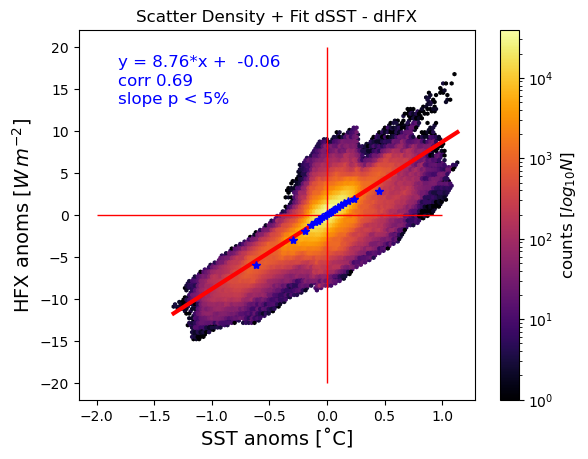

In [26]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x = (sst_day-273.15).copy()*mask      
    y = HFX.copy()*mask
    
    xx, yy = pdist_sst-273.15, pdist_HFX
    
    fit_hfx, corcoe_hfx, p_value_hfx, p_value_cannelli_hfx, sigmas_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - HFX'
    xlabel='SST [˚C]'
    ylabel=r'HFX [$W\,m^{-2}$]'
else:
    x = dsst_day.values.copy()*mask
    y = dHFX.copy()*mask
    
    xx, yy = pdist_x, pdist_dHFX
    
    fit_hfx, corcoe_hfx, p_value_hfx, p_value_cannelli_hfx, sigmas_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dHFX'
    xlabel='SST anoms [˚C]'
    ylabel=r'HFX anoms [$W\,m^{-2}$]'
    miny = -20 ; maxy = -miny
    minx = -2 ; maxx = 1

    
pos = [0.1, 0.9]
fig = density_hexbin(x,y,plot_fit=True,fit=fit_hfx,corcoe=corcoe_hfx,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)
plt.plot(xx, yy, '*b')
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''
if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
    
if p_value_cannelli_hfx < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')


path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dHFX_fullDom.png' if dsst else path_img + 'scatterFIT_sst_HFX_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    PBLH     #########

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

In [16]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask_modified, drop=False).values;

In [17]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


# pres = pres.where(sea_mask_modified, drop=False)


del pres_base

In [18]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
pres_sfc = pres_sfc.where(sea_mask_modified, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

del pres

In [ ]:
## load saturation vapour pressure
## computed in RH_calculation_only.ipynb

In [21]:
# qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
# qsat_sst = qsat_sst*sea_mask_modified_nan

# dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')
# dqsat_sst = dqsat_sst*sea_mask_modified_nan

In [20]:
# #### DEBUG -- giusto
# s = 100
# dqsat_sst_debug = np.zeros_like(dqsat_sst)

# for t in range(0,dqsat_sst_debug.shape[0]):
#     if t % 10 == 0:
#         print(t)
#     # upscale using gaussian filter
#     qsat_smooth = gm.nan_gaussian_filter(qsat_sst[t],s)                             
#     dqsat_sst_debug[t] = qsat_sst[t] - qsat_smooth
    
# dqsat_sst = dqsat_sst_debug
# del dqsat_sst_debug

0
10
20


In [22]:
# delta_q = qsat_sst*units('g/kg') - q2_day*units('kg/kg') ;   delta_q = delta_q.to('g/kg')

In [29]:
# my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy', [delta_q.magnitude])

file already exists - DELETING IT and creating it anew


In [10]:
# delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')

In [22]:
# qsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy')
# qsat_2m = qsat_2m*sea_mask_modified_nan

# dqsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_2m_day.npy')
# dqsat_2m = dqsat_2m*sea_mask_modified_nan


In [23]:
# d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')
# d_delta_q = d_delta_q*sea_mask_modified_nan 

In [24]:
# dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')
# dq2 = dq2*sea_mask_modified_nan

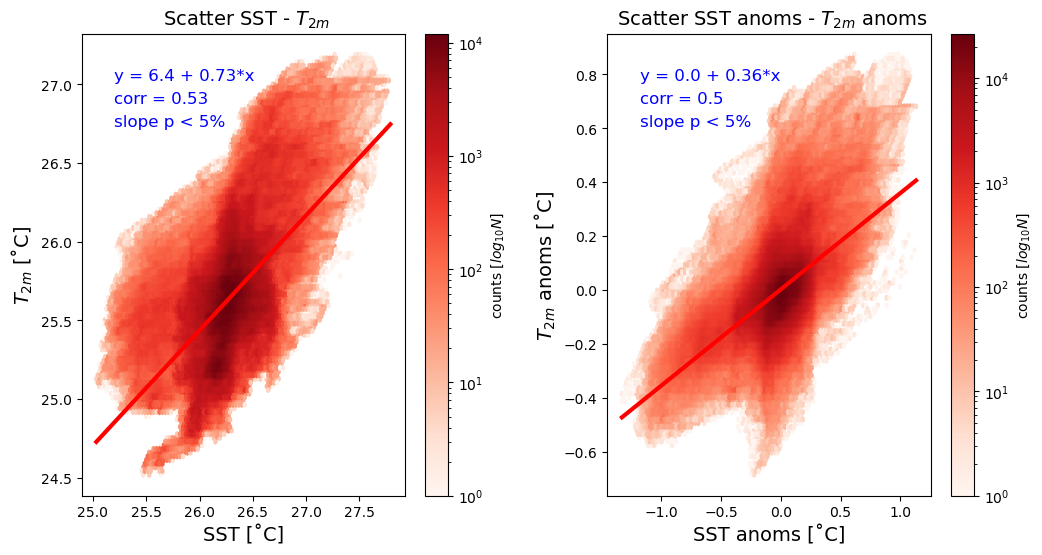

In [26]:
#####  LINKING T2 WITH SST


# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = False

x =  sst_day*mask-273.15
y =  T2*mask-273.15
fit_T2_sst, corcoe_T2_sst, p_value_T2_sst, p_value_cannelli_T2_sst, sigmas_coeffs_T2_sst = slopes_r_p_mix(x, y, nt, nskip)
   
density_hexbin_subplots(x, y, fit=fit_T2_sst, corcoe=corcoe_T2_sst, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $T_{2m}$', xlabel='SST [˚C]', ylabel='$T_{2m}$ [˚C]', colormap='Reds', pos=[0.1,0.9])
    

    
if p_value_cannelli_T2_sst < 0.05:
    ax1.annotate('slope p < 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    

    
    
    
xx = dsst_day.values*mask
yy = dT2*mask
fit_dT2_dsst, corcoe_dT2_dsst, p_value_dT2_dsst, p_value_cannelli_dT2_dsst, sigmas_coeffs_dT2_dsst = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_dT2_dsst, corcoe=corcoe_dT2_dsst, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST anoms - $T_{2m}$ anoms', xlabel='SST anoms [˚C]', ylabel='$T_{2m}$ anoms [˚C]', colormap='Reds', pos=[0.1,0.9])




if p_value_cannelli_dT2_dsst < 0.05:
    ax2.annotate('slope p < 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p > 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')



plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)

# path_img = '/venus/tesi_ale/img_EU/T/daily/FEB/' 
# filename = path_img + 'scatterFIT_T2-sst_dT2-dsst_fullDom.png' # if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
# # plt.savefig(filename)
# print(filename)
# del filename

In [21]:
pdist_sst, pdist_TDiff, pstd_TDiff, pstderr_TDiff, pnpoints_TDiff, ppvalue_TDiff =   distrib_2d(sst_day, T_diff, perc_step, nbins, popmean, perc_fixbin='perc')
pdist_dsst, pdist_dTDiff, pstd_dTDiff, pstderr_dTDiff, pnpoints_dTDiff, ppvalue_dTDiff =   distrib_2d(dsst_day.values, dT_diff, perc_step, nbins, popmean, perc_fixbin='perc')


In [38]:
xx

array([298.76367188, 299.07727051, 299.17199707, 299.23574829,
       299.27871704, 299.31222534, 299.34140015, 299.36764526,
       299.39221191, 299.41586304, 299.43927002, 299.46417236,
       299.49172974, 299.5234375 , 299.56164551, 299.60565186,
       299.65640259, 299.72381592, 299.81686401, 300.09268188])

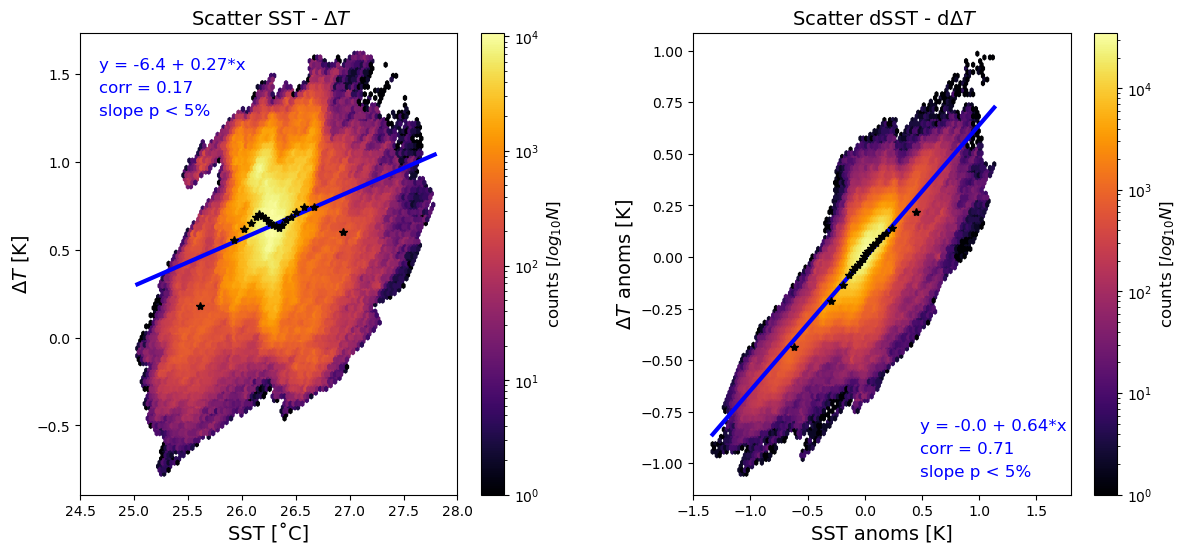

In [22]:
# slope p value > 0.05# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
mask = sea_mask_modified_nan


x =  (sst_day-273.15);    x = x*mask
y =  T_diff;                      y = y*mask

xx = pdist_sst-273.15
yy = pdist_TDiff

fit_TDiff_sst, corcoe_TDiff, p_value_TDiff, p_value_cannelli_TDiff, sigmas_coeffs_TDiff = slopes_r_p_mix(x, y, nt, nskip)
ls_therm_contr = fit_TDiff_sst.slope
   
density_hexbin_subplots(x, y, fit=fit_TDiff_sst, corcoe=corcoe_TDiff, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $\Delta T$', xlabel='SST [˚C]', ylabel='$\Delta T$ [K]', colormap='inferno', pos=[0.05,0.92])
ax1.set_xlim([24.5, 28])    

ax1.plot(xx, yy, '*k')

if p_value_cannelli_TDiff < 0.05:
    ax1.annotate('slope p < 5%', xy=(0.05, 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(0.05, 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')

    
    
    
###############################################
    
xxx = dsst_day.values;     xxx = xxx*mask
yyy = dT_diff;             yyy = yyy*mask


xxxx, yyyy = pdist_dsst, pdist_dTDiff

fit_dTDiff_dsst, corcoe_dTDiff, p_value_dTDiff, p_value_cannelli_dTDiff, sigmas_coeffs_dTDiff = slopes_r_p_mix(xxx, yyy, nt, nskip)
ss_therm_contr = fit_dTDiff_dsst.slope

density_hexbin_subplots(xxx, yyy, fit=fit_dTDiff_dsst, corcoe=corcoe_dTDiff, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter dSST - d$\Delta T$', xlabel='SST anoms [K]', ylabel='$\Delta T$ anoms [K]', colormap='inferno', pos=[0.6,0.14])
ax2.set_xlim([-1.5, 1.8])

ax2.plot(xxxx, yyyy, '*k')



if p_value_cannelli_dTDiff < 0.05:
    ax2.annotate('slope p < 5%', xy=(0.6, 0.04), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p > 5%', xy=(0.6, 0.04), \
                         xycoords='axes fraction', fontsize=12, color='b')


    

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)


######  PREVIOUSLY SAVED IN QVAPOR  #######
# path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
# filename = path_img + 'scatterFIT_dsst_dQsat_dQ2_fullDom.png' if anoms else path_img + 'scatterFIT_sst_Qsat_Q2_fullDom.png'
# print(filename)
# # plt.savefig(filename)
# del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

In [ ]:
sigmas_coeffs_TDiff, sigmas_coeffs_dTDiff

In [24]:
sst_smooth = sst_day - dsst_day.values;   sst_smooth -= 273.15


In [25]:

pdist_sst_sm, pdist_TDiff_sm, pstd_TDiff_sm, pstderr_TDiff_sm, pnpoints_TDiff_sm, ppvalue_TDiff_sm =   distrib_2d(sst_smooth, T_diff_smooth, perc_step, nbins, popmean, perc_fixbin='perc')


In [30]:
sigmas_coeffs_TDiff_sm

(0.15889460485568666, 4.178073260983203)

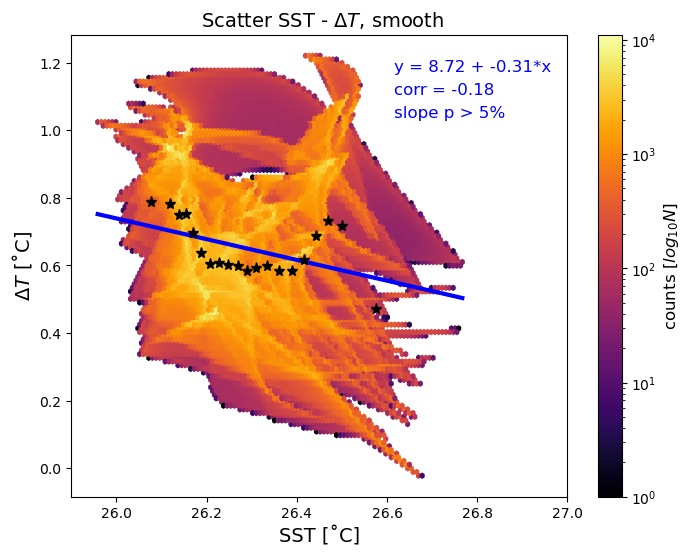

In [47]:
# slope p value > 0.05# variaiton of qsat and q2 with SST and dSST
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

anoms = True

nskip_sm = 200

x =  sst_smooth;                         x = x*mask
y =  T_diff_smooth;                      y = y*mask

xx = pdist_sst_sm
yy = pdist_TDiff_sm

fit_TDiff_sst_sm, corcoe_TDiff_sm, p_value_TDiff_sm, p_value_cannelli_TDiff_sm, sigmas_coeffs_TDiff_sm = slopes_r_p_mix(x, y, nt, nskip = nskip_sm)
smooth_therm_contr = fit_TDiff_sst_sm.slope

pos = [0.65,0.92]
density_hexbin_subplots(x, y, fit=fit_TDiff_sst_sm, corcoe=corcoe_TDiff_sm, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $\Delta T$, smooth', xlabel='SST [˚C]', ylabel='$\Delta T$ [˚C]', colormap='inferno', pos=pos)
ax1.set_xlim([25.9, 27])    

ax1.plot(xx, yy, '*k', markersize=8)

if p_value_cannelli_TDiff_sm < 0.05:
    ax1.annotate('slope p < 5%', xy=(pos[0], 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(pos[0], 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')

In [31]:
pdist_sst_sm, pdist_HFX_sm, pstd_HFX_sm, pstderr_HFX_sm, pnpoints_HFX_sm, ppvalue_HFX_sm =   distrib_2d(sst_smooth, HFX_smooth, perc_step, nbins, popmean, perc_fixbin='perc')

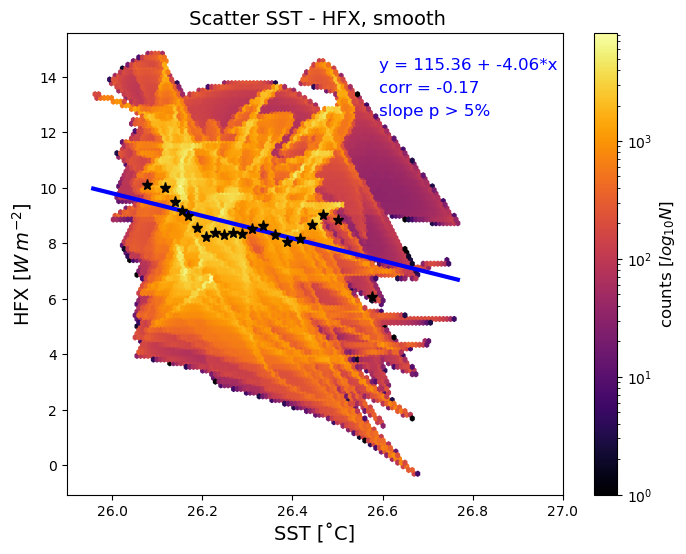

In [34]:
# slope p value > 0.05# variaiton of qsat and q2 with SST and dSST
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

anoms = True
nskip_sm = 200

x =  sst_smooth;                         x = x*mask
y =  HFX_smooth;                         y = y*mask

xx = pdist_sst_sm
yy = pdist_HFX_sm

fit_HFX_sst_sm, corcoe_HFX_sm, p_value_HFX_sm, p_value_cannelli_HFX_sm, sigmas_coeffs_HFX_sm = slopes_r_p_mix(x, y, nt, nskip_sm)
# smooth_therm_contr = fit_TDiff_sst_sm.slope

pos = [0.63,0.92]
density_hexbin_subplots(x, y, fit=fit_HFX_sst_sm, corcoe=corcoe_HFX_sm, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - HFX, smooth', xlabel='SST [˚C]', ylabel='HFX [$W\,m^{-2}$]', colormap='inferno', pos=pos)
ax1.set_xlim([25.9, 27])    

ax1.plot(xx, yy, '*k', markersize=8)

if p_value_cannelli_HFX_sm < 0.05:
    ax1.annotate('slope p < 5%', xy=(pos[0], 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(pos[0], 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')

In [ ]:
###### trying to estimate aerodynamic coefficient

In [36]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')*mask
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')*mask

ws = np.sqrt(U**2+V**2)

# I KNOW THIS IS WRONG, I SHOULD CORRECT IT FOR THE LOG PROFILE
ws_10 = ws[:,0,:,:] #(ws[:,0,:,:]+ws[:,1,:,:])*0.5 

del U, V, ws

In [37]:
## trying to estimate air density, see if ths changes the estimate of C
T_virt = (T2*units.kelvin)*(1+0.61*q2_day*units('kg/kg'))
Rd = 287.058
rho_air = pres_sfc*100/(Rd*T_virt.magnitude)   # pressure is in hPa

In [38]:
cp = 1004  # units = J/kgK  ; function in meteo.py is a correction of order 10^4/10^6 = 10^-2

ingredients = cp*ws_10*(T_diff) # units = J/kg * m/s
ingredients_rho = rho_air*cp*ws_10*(T_diff) #  # units = W/m2

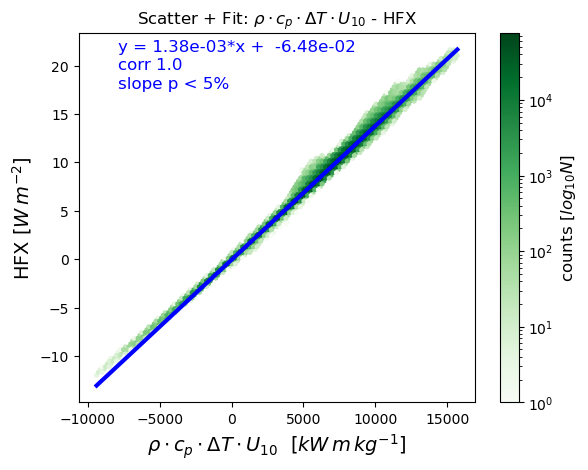

In [39]:
# FIT FOR    C

x = ingredients_rho.values.copy()*mask 
y = HFX.copy()*mask

fit_rho, corcoe_rho, p_value_rho, p_value_cannelli_rho, sigmas_coeffs_rho = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $\rho \cdot c_p \cdot \Delta T \cdot U_{10}$ - HFX'
xlabel=r'$\rho \cdot c_p \cdot \Delta T \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='HFX [$W\,m^{-2}$]'

# plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3),200*(10**3), 225*(10**3)],\
#            ['25', '50', '75', '100', '125', '150','175', '200', '225'])  
 

fig = density_hexbin(x,y,plot_fit=True,fit=fit_rho,corcoe=corcoe_rho,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_rho < 0.05:
    plt.annotate('slope p < 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
# path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
# filename = path_img + 'scatterFIT_C_fullDom.png'
# # plt.savefig(filename)
# print(filename)
# del filename

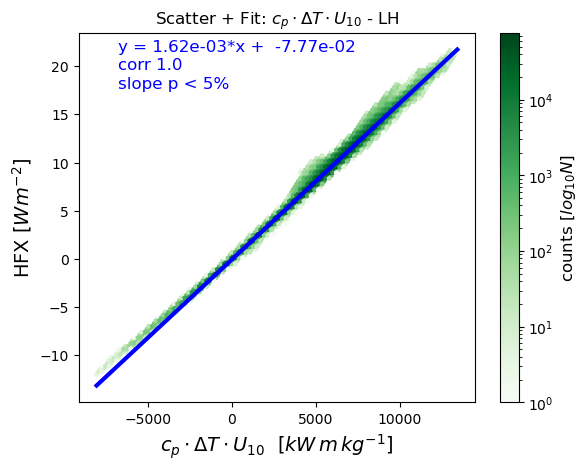

In [40]:
# FIT FOR    rho C

x = (ingredients.copy()*mask)
y = HFX.copy()*mask

fit_hfx, corcoe_hfx, p_value_hfx, p_value_cannelli_hfx, sigmas_coeffs_hfx = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $c_p \cdot \Delta T \cdot U_{10}$ - LH'
xlabel=r'$c_p \cdot \Delta T \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='HFX [$Wm^{-2}$]'

# plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3)],\
#            ['25', '50', '75', '100', '125', '150','175'])   # 200*(10**3), 225*(10**3)  # , '200', '225'
 

fig = density_hexbin(x,y,plot_fit=True, fit=fit_hfx,corcoe=corcoe_hfx,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_hfx < 0.05:
    plt.annotate('slope p < 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')

    
# path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
# filename = path_img + 'scatterFIT_rho-C_fullDom.png'
# # plt.savefig(filename)
# print(filename)
# del filename

In [41]:
rho_C = round(fit_hfx.slope, 4);    sigma_rhoC = round(sigmas_coeffs_hfx[0], 5)
C = round(fit_rho.slope, 4);       sigma_C = round(sigmas_coeffs_rho[0], 5)

#### RESULT IS VERY MUCH IN LINE WITH VALUE USED BY PABLO!
#### THERE IS ONLY THAT INTERCEPT RUINING THE PARTY

msg = f'C = {C} ± {sigma_C}\nrho_C = {rho_C} ± {sigma_rhoC} \nrelative errors respectively {round(sigma_C/C, 4)} and {sigma_rhoC/rho_C}'
print(msg)

C = 0.0014 ± 1e-05
rho_C = 0.0016 ± 1e-05 
relative errors respectively 0.0071 and 0.00625


In [42]:
# find most frequent thermodyn contr
ws_10_mode = np.mean(ws_10[~np.isnan(ws_10)], axis=None)
rho_mode = np.mean(rho_air.values[~np.isnan(rho_air.values)], axis=None)

In [43]:
print(f'full fields rho_C = {round(rho_C*cp*ls_therm_contr*(ws_10_mode),3)} W/m2')
print(f'full fields C     = {round((rho_mode)*C*cp*ls_therm_contr*(ws_10_mode),3)} W/m2')
print('\n')
print(f'small scale rho_C = {round(rho_C*cp*ss_therm_contr*(ws_10_mode),3)} W/m2')
print(f'small scale C     = {round((rho_mode)*C*cp*ss_therm_contr*(ws_10_mode),3)} W/m2')

full fields rho_C = 3.602 W/m2
full fields C     = 3.69 W/m2


small scale rho_C = 8.653 W/m2
small scale C     = 8.863 W/m2


So far, I have been comparing the FULL FIELDS with ANOMALIES

I am now to study the actual differences between SMOOTH FIELDS and ANOMALIES --> SPLIT THE SPECTRUM!!

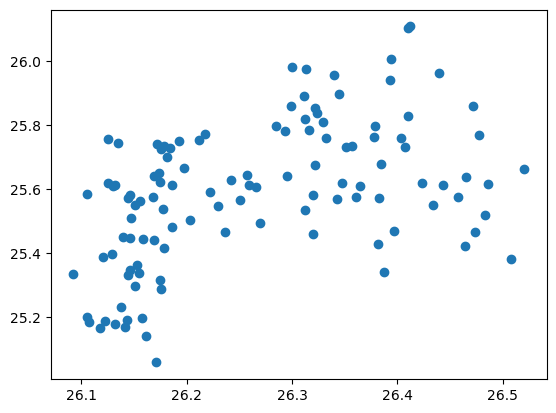

In [24]:
x =  sst_smooth;  x = x[:,::200, ::200]
y =  T2_smooth-273.15;  y = y[:,::200, ::200]

plt.scatter(x, y)
# density_hexbin(x, y, plot_fit = False, fit=None, corcoe=None, grdsz=100,\
#                         title=r' Scatter + Fit SST smooth - $T_{2m}$ smooth', xlabel='SST smooth [˚C]', ylabel=r'$T_{2m}$ smooth [˚C]', colormap='Reds', pos=[0.1, 0.9])

/venus/tesi_ale/img_EU/RH/daily/FEB/scatterFIT_T2-smooth_sst-smooth_feb.png


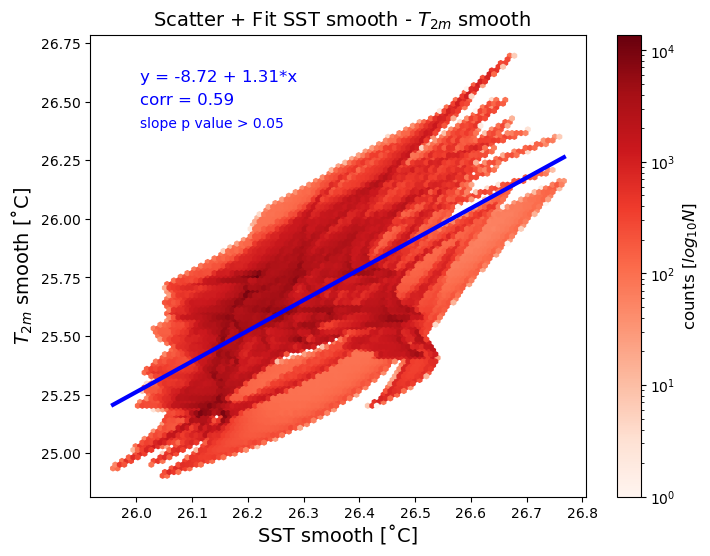

In [22]:
d (SST - T2) (large scale) / dSST(large scale)####### CHECK THAT FULL T2 vs SST
####### FOLLOWS T2 vs SST smooth

fig, ax = plt.subplots(1,1, figsize=(8,6))
nskip_smooth = 100

x =  sst_smooth
y =  T2_smooth-273.15
fit_T2_sst_sm, corcoe_T2_sst_sm, p_value_T2_sst_sm, p_value_cann_T2_sst_sm, sigmas_T2_sst_sm = slopes_r_p_mix(x, y, nt, nskip_smooth)

hfx_sensitivity_smooth = fit_T2_sst_sm.slope

pos = [0.1, 0.9]
density_hexbin_subplots(x, y, fit=fit_T2_sst_sm, corcoe=corcoe_T2_sst_sm, grdsz=100, fig=fig, ax=ax,\
                        title=r' Scatter + Fit SST smooth - $T_{2m}$ smooth', xlabel='SST smooth [˚C]', ylabel=r'$T_{2m}$ smooth [˚C]', colormap='Reds', pos=pos)
    

    
if p_value_cann_T2_sst_sm < 0.05:
    ax.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')

    
    
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename    


0.5141983737969724

In [78]:
sigmas_coeffs_dTDiff

(0.052056410277308895, 0.011311572243818638)

In [44]:
data1 = rho_C*cp*ws_10*ls_therm_contr*mask; data1 = data1[~np.isnan(data1)]
data2 = rho_C*cp*ws_10*ss_therm_contr*mask; data2 = data2[~np.isnan(data2)]
data3 = C*cp*ws_10*ls_therm_contr*mask;     data3 = data3[~np.isnan(data3)]
data4 = C*cp*ws_10*ss_therm_contr*mask;     data4 = data4[~np.isnan(data4)]

data5 = rho_C*cp*ws_10*smooth_therm_contr;   data5 = data5[~np.isnan(data5)]
data6 = C*cp*ws_10*smooth_therm_contr;       data6 = data6[~np.isnan(data6)]

In [48]:
sigmass = [sigmas_coeffs_TDiff[0], sigmas_coeffs_TDiff[0], sigmas_coeffs_dTDiff[0], sigmas_coeffs_dTDiff[0], sigmas_coeffs_TDiff_sm[0], sigmas_coeffs_TDiff_sm[0]]
slopes = [ls_therm_contr, ls_therm_contr, ss_therm_contr, ss_therm_contr, smooth_therm_contr, smooth_therm_contr]


In [49]:
sigmass

[0.10724569161618694,
 0.10724569161618694,
 0.052056410277308895,
 0.052056410277308895,
 31.454030788571313,
 31.454030788571313]

Text(0.5, 0, '')

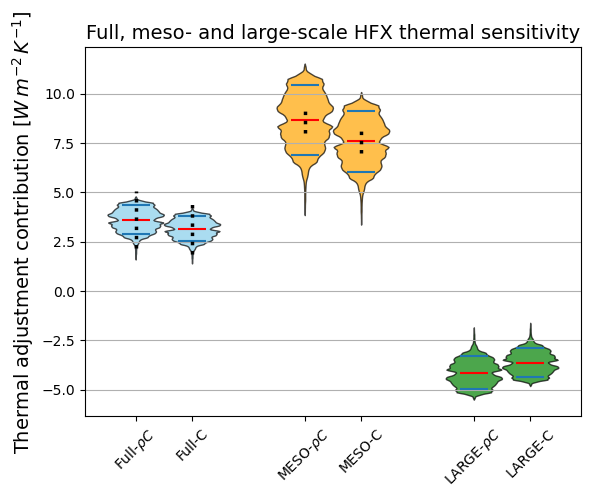

In [52]:

fig, axs = plt.subplots(1,1)
quants = [[0.1, 0.9] , [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]
pos = [ 1, 1.5, 2.5, 3., 4, 4.5]
colorz = ['skyblue', 'skyblue', 'orange', 'orange' , 'green', 'green']


plt.title('Full, meso- and large-scale HFX thermal sensitivity', fontsize=14)


violin_parts1 = axs.violinplot([data1, data3, data2, data4, data5, data6],\
                               positions=pos, showmeans=False,\
                               showmedians=True, showextrema=False, quantiles=quants)
violin_parts1['cmedians'].set_color('red')



# set color of violins inside
for pc, color in zip(violin_parts1['bodies'], colorz):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

    
for i, dataset in enumerate([data1, data3, data2, data4]):  #, data5, data6]):
    if int(i)%2 == 0:
        k = rho_C
    else:
        k = C
    
    up = k*cp*ws_10*(slopes[i]+sigmass[i])*mask;  up = up[~np.isnan(up)]
    dn = k*cp*ws_10*(slopes[i]-sigmass[i])*mask;  dn = dn[~np.isnan(dn)]

    med_up, med_dn = np.nanmedian(up), np.nanmedian(dn)
    axs.plot([pos[i], pos[i]], [med_dn, med_up], linestyle='dotted', color='k', lw=2.5)
    

# set labels I need
axs.yaxis.grid(True)
axs.set_ylabel(r'Thermal adjustment contribution [$W\,m^{-2}\,K^{-1}$]', fontsize=14)

axs.set_xticks(pos)
axs.set_xticklabels([r'Full-$\rho C$','Full-C', r'MESO-$\rho C$', 'MESO-C', r'LARGE-$\rho C$', 'LARGE-C'], rotation=45)  # , 
axs.set_xlabel('')



# save img
# path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
# filename = path_img + 'violins_full-SS-LS_rho-C_fullDom.png'
# # plt.savefig(filename)
# print(filename)
# del filename